# <center> Stroke Prediction - Final Notebook
## <center> Notebook Overview
Here be the overview of what this notebook entails.

## <center> Executive Summary
Here be the executive summary of the work done in this notebook.
    
## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score, accuracy_score

import prepare
import model

# <center> 1. Wrangle
## Wrangle Overview
1. Acquired dataset from Kaggle
1. Dropped outliers in BMI and gender columns
1. Renamed columns, cast columns to appropriate data types, dropped unnecessary columns
1. Imputed nulls in BMI column using average BMI for age range and gender
1. Plotted univariate distributions to check work
1. Noticed class imbalance and need for SMOTE+Tomek resampling
1. Encoded categorical columns identified from univariate distributions
1. Converted ordinal values from 1s and 0s to True and False values from univariate distributions
1. Created bmi_range column for BMI grouping from univariate distributions
1. Created high_glucose feature based on Explore analysis
1. Created is_senior feature based on Explore analysis
1. Split data into Train, Validate, and Test splits

## Cleaning the Data
First up, we need to clean the dataset for exploration. The specific steps are described above. These steps were put to a function in prepare.py, which we call in the following cell.

In [2]:
# Use the prep_data function to prepare the data
df = prepare.prep_data(pd.read_csv('healthcare-dataset-stroke-data.csv'))

# Check results
print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns.')
df.head(3)

Shape: 5107 rows, 12 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1,60-65
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75-80


## Univariate Distribution Plots
Here, we will check to make sure our distributions look okay. 

------------------------------   gender   ------------------------------


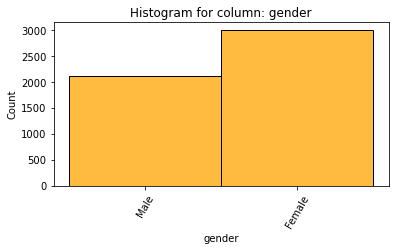

------------------------------   age   ------------------------------


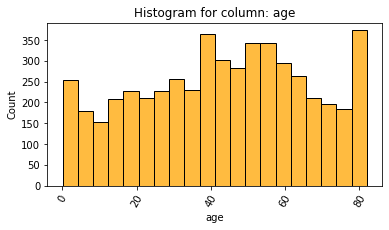

------------------------------   hypertension   ------------------------------


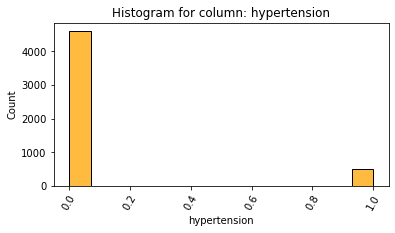

------------------------------   heart_disease   ------------------------------


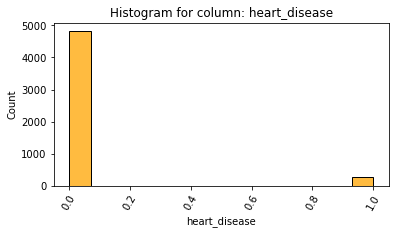

------------------------------   ever_married   ------------------------------


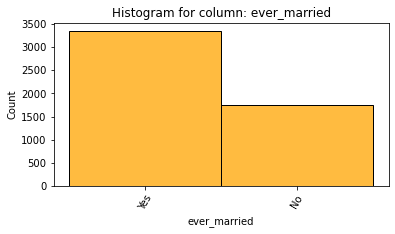

------------------------------   work_type   ------------------------------


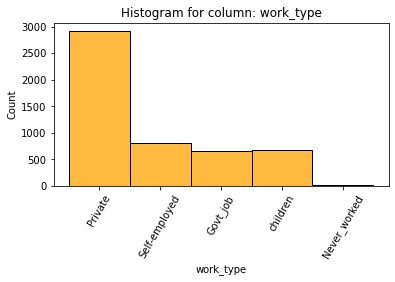

------------------------------   residence_type   ------------------------------


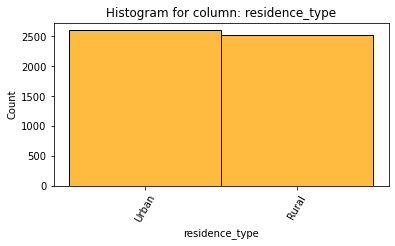

------------------------------   avg_glucose_level   ------------------------------


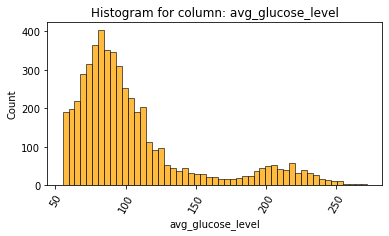

------------------------------   bmi   ------------------------------


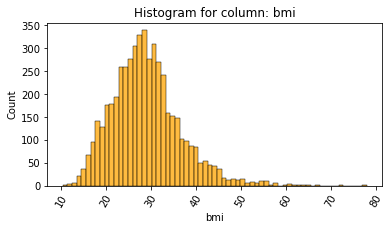

------------------------------   smoking_status   ------------------------------


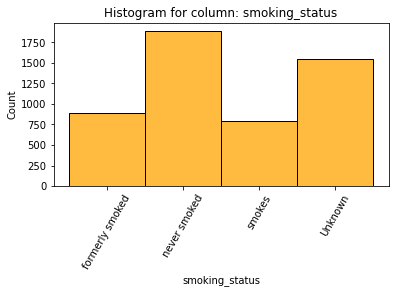

------------------------------   stroke   ------------------------------


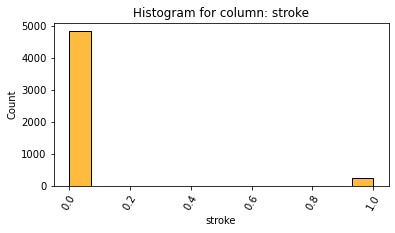

------------------------------   age_range   ------------------------------


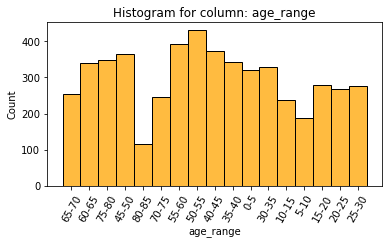

In [3]:
# Plot univariate distributions for each column
for col in df.columns:
    plt.figure(figsize=(6,3))
    print('-'*30, ' ', col, ' ', '-'*30) # use a line separator charts
    sns.histplot(df[col], color='#ffa500')
    plt.title('Histogram for column: ' + col)
    plt.xticks(rotation=60)
    plt.show()

## Need for SMOTE + Tomek Oversampling
Our target is imbalanced, as can be seen below. We will need to use SMOTE + Tomek Oversampling later on in the Modeling section to train our classification models with balanced classes.

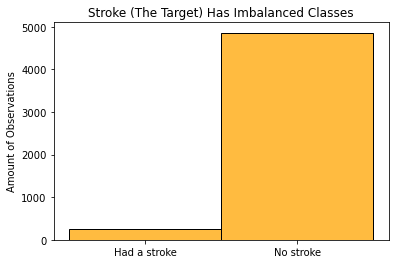

In [4]:
# Plot histogram showing class imbalance in 'stroke' column
sns.histplot(np.where(df.stroke == 1, 'Had a stroke', 'No stroke'), color='#ffa500')
plt.title('Stroke (The Target) Has Imbalanced Classes')
plt.ylabel('Amount of Observations')
plt.show()

## Feature Engineering
From these univariate distributions, we've decided to modify some features for exploration purposes. We've also incorporated some feature engineering based on analysis done in the Explore stage. This work is captured by the engineer_features function in prepare.py. 

Note: *We've combined the 'children' work type and the 'Never_worked' work type because there was overlap for those under 18 years old having the latter work type.* All other features are simply encoded or have additional columns with categorization.

In [5]:
# engineer features
engineered_df = prepare.engineer_features(df)

Original shape: 5107 rows, 12 columns.
New shape: 5107 rows, 21 columns.


In [6]:
# check results
engineered_df.head(3)

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,...,is_female,is_urban,smoking_status,current_smoker,prior_smoker,never_smoked,govt_job,self_employed,private_work,never_worked
0,1,67.0,65-70,True,36.6,30-39,228.69,True,False,True,...,False,True,formerly smoked,False,True,False,False,False,True,False
1,1,61.0,60-65,True,30.6,30-39,202.21,True,False,False,...,True,False,never smoked,False,False,True,False,True,False,False
2,1,80.0,75-80,True,32.5,30-39,105.92,False,False,True,...,False,False,never smoked,False,False,True,False,False,True,False


## Split data for Exploration
In order to explore on in-sample data, we will split our dataset into in-sample data and out-of-sample data. We will use the two out-of-sample splits for modeling purposes. Our splits are 60% in-sample and 20% for each out-of-sample split.

In [7]:
# Split data 60-20-20 into Train, Validate, and Test splits
train_validate, test = train_test_split(engineered_df, test_size=0.2, random_state=777)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=777)

print(f'Train shape: {train.shape}, Validate shape: {validate.shape}, Test shape: {test.shape}')
print('Row count of original dataset:', df.shape[0])
print('Row count of combined data splits:', train.shape[0] + validate.shape[0] + test.shape[0])

Train shape: (3063, 21), Validate shape: (1022, 21), Test shape: (1022, 21)
Row count of original dataset: 5107
Row count of combined data splits: 5107


## Wrangle Summary
- Cleaned the dataset
- Checked distributions, noticed class imbalance
- Engineered features in preparation for exploration
- Split data

# <center>2. Explore
## Exploration Overview
1. Answered initial hypotheses
1. *Bivariate:* Split features on No Stroke and Had Stroke, visualized differences
1. Eliminated features that weren't significantly different between No Stroke and Had Stroke
1. Determined that 'age' might be causing some features to seem as if they have a dependent relationship with 'stroke'
1. *Multivariate:* Split features on 'age' and 'stroke' using 55 years old as the split point, visualized differences
1. Eliminated features that did not have a dependent relationship to stroke in either of the isolated under-55 and over-55 age groups
1. Incorporated remaining features into prepare script for modeling

## Initial Hypotheses
Before analyzing this data, our team created four initial hypotheses:
- Hypothesis 1: On average, an increase in BMI corresponds with an increase in average glucose level.
- Hypothesis 2: On average, a person who has had a stroke is older than someone who has not.
- Hypothesis 3: Smoking has an impact on stroke occurrence.
- Hypothesis 4: Men are more at risk for stroke than women.

The following work answers these hypotheses.

### Hypothesis 1: On average, an increase in BMI corresponds with an increase in average glucose level.
> - $H_0$ : An increase in BMI does not correspond with an increase in average glucose level.
> - $H_a$ : An increase in BMI corresponds with an increase in average glucose level.
> - Confidence interval is 95%

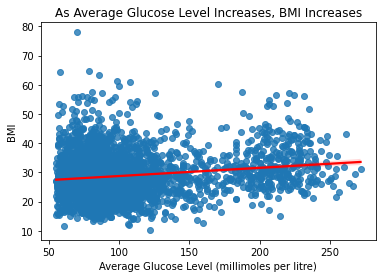

In [8]:
# visualize: use regression plot to check linear trend
sns.regplot(data=train, x="avg_glucose_level", y="bmi", line_kws={'color': 'red'})
plt.title('As Average Glucose Level Increases, BMI Increases')
plt.xlabel('Average Glucose Level (millimoles per litre)')
plt.ylabel('BMI')
plt.show()

In [9]:
# statistical test: set alpha for test
alpha = .05

# statistical test: conduct pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)

# statistical test: output results
if p < alpha and corr > 0:
    print('We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.')
else:
    print('We can not say with 95% confidence that an increase in BMI corresponds with an increase in average glucose level.')

We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.


### Hypothesis 2: On average, a person who has had a stroke is older than someone who has not.
> - $H_0$ : A person who has had a stroke is not statistically-significantly older than someone who has not.
> - $H_a$ : A person who has had a stroke is statistically-significantly older than someone who has not.
> - Confidence interval is 95%

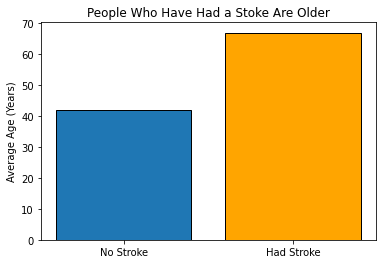

In [10]:
# prepare: split samples into two dataframes
had_stroke = train.stroke == 1

# visualize: build data for bar plot
x = ['No Stroke', 'Had Stroke']
y = [round(train[had_stroke == False].age.mean()),
     round(train[had_stroke].age.mean())]

# visualize: apply data to bar plot
plt.bar(x=x, height=y, color=['#1f77b4','#ffa500'], ec='black')
plt.title('People Who Have Had a Stoke Are Older')
plt.ylabel("Average Age (Years)")
plt.show()

In [11]:
# statistical test: set alpha
alpha = .05

# statistical test: conduct chi2 contingency test
stroke = train.stroke == 1
no_stroke = train.stroke == 0
t, p = stats.mannwhitneyu(train[stroke].age, train[no_stroke].age, alternative='greater')

# statistical test: output results
if p < alpha:
    print('We are 95% confident that people who have had a stroke are older on average than people who have not.')
else:
    print('We can not say with 95% confidence that people who have had a stroke are older on average than people who have not.')

We are 95% confident that people who have had a stroke are older on average than people who have not.


### Hypothesis 3: Smoking has an impact on stroke occurrence.
> - $H_0$ : Smoking does not have an impact on stroke occurrence.
> - $H_a$ : Smoking has an impact on stroke occurrence.
> - Confidence interval is 95%

In [12]:
# prepare: eliminate unknowns, split rest into ever-smoked and never-smoked
know_smoke_status = train[train.smoking_status != 'Unknown']
know_smoke_status['smokers'] = ((know_smoke_status['smoking_status'] == 'smokes') | 
                                (know_smoke_status['smoking_status'] == 'formerly smoked'))

# prepare: create crosstab of samples and stroke occurrence for chi2 test
smoker_crosstab = know_smoke_status.groupby('smokers').stroke.value_counts().unstack()

# prepare: add labels to crosstab
smoker_crosstab.rename(columns={0:'No Stroke', 1:'Had Stroke'}, 
                       index={0:'Not Smokers', 1:'Smokers'}, 
                       inplace=True)

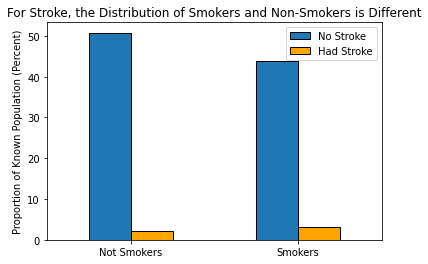

In [13]:
# visualize: convert dataframe counts to percentages
smoker_crosstab_total = smoker_crosstab.values.sum()
smoker_viz = (smoker_crosstab / smoker_crosstab_total) * 100

# visualize: plot the percentages
smoker_viz.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('For Stroke, the Distribution of Smokers and Non-Smokers is Different')
plt.xlabel('')
plt.ylabel('Proportion of Known Population (Percent)')
plt.legend()
plt.show()

In [14]:
# statistical test: set alpha
alpha = .05

# statistical test: run chi2 test
_, p, _, _ = stats.chi2_contingency(smoker_crosstab)

# statistical test: output results
if p < alpha:
    print('We are 95% confident that smoking has an impact on stroke occurrence.')
else:
    print('We can not say with 95% confidence that smoking has an impact on stroke occurrence.')

We are 95% confident that smoking has an impact on stroke occurrence.


### Hypothesis 4: Men and women have different stroke occurrence rates.
> - $H_0$ : Men and women do not have different stroke occurrence rates.
> - $H_a$ : Men and women have different stroke occurrence rates.
> - Confidence interval is 95%

In [15]:
# prepare: create new column for crosstab
train['is_female'] = np.where(train['is_female'] == "True", "Female", "Male")

# prepare: create crosstab of samples and stroke occurrence for chi2 test
gender_crosstab = pd.crosstab(train['is_female'], train['stroke'])

# prepare: add labels
gender_crosstab.rename(columns={0:'No Stroke', 1:'Had Stroke'}, 
                       index={0:'Male', 1:'Female'},
                       inplace=True)

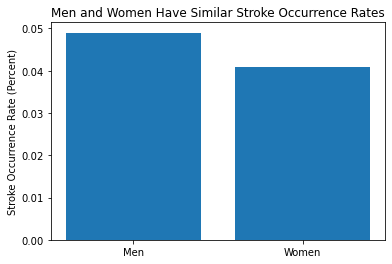

In [16]:
# visualize: create samples for men and women
men = train[train.is_female == "Male"]
women = train[train.is_female == "Female"]

# visualize: plot sample means for stroke
x = ['Men', 'Women']
y = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]

plt.bar(x=x, height=y)
plt.title('Men and Women Have Similar Stroke Occurrence Rates')
plt.ylabel("Stroke Occurrence Rate (Percent)")
plt.show()

In [17]:
# statistical test: set alpha
alpha = .05

# statistical test: run chi2 test
_, p, _, expected = stats.chi2_contingency(gender_crosstab)

# statistical test: output results
if p < alpha:
    print('We are 95% confident that men and women have different stroke occurrence rates.')
else:
    print("We can't say with 95% confidence that men and women have different stroke occurrence rates.")

We can't say with 95% confidence that men and women have different stroke occurrence rates.


### Initial Hypotheses - Combined Results
> #### We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.
> #### We are 95% confident that people who have had a stroke are older on average than people who have not.
> #### We are 95% confident that smoking has an impact on stroke occurrence.
> #### We can't say with 95% confidence that men and women have different stroke occurrence rates.

## Initial Bivariate Analysis
Our first step after testing initial hypotheses is to explore how features are distributed for No Stroke and Had Stroke, our two target classes. Below, we run stats tests and generate visualizations for all features and both of the target classes. 

### Continuous Independent Variables and Stroke - Comparison of Means

In [18]:
# select continuous columns
cont_cols = ['age','bmi','avg_glucose_level']
# init empty statement dict to post with bivariate visualizations
statement_dict = {}
# loop through mannwhitneyu tests for whether stroke/not-stroke samples are different on col
for col in cont_cols:
    # set alpha
    alpha = .05
    # test
    t, p = stats.mannwhitneyu(train[train.stroke == 0][col], 
                              train[train.stroke == 1][col],
                              alternative='two-sided')
    # save statement
    if t != 0 and p < alpha / 2:
        statement = f"Mean value of '{col}' between had-stroke and no-stroke is significantly different."
    else:
        statement = f"Mean value of '{col}' between had-stroke and no-stroke is not significantly different."
    # add statement to dict
    statement_dict[col] = statement

### Categorical Intependent Variables and Stroke - Independence Testing

In [19]:
# select categorical columns
cat_cols = train.columns[7:].tolist()
# loop through chi-square contingency tests to see if stroke is dependent
for col in cat_cols:
    # set alpha
    alpha = .05
    # create crosstab
    stroke_col_crosstab = pd.crosstab(train[col], train['stroke'])
    # test
    _, p, _, _ = stats.chi2_contingency(stroke_col_crosstab)
    # save statement
    if p < alpha:
        statement = f"The 'stroke' and '{col}' columns are dependent."
    else:
        statement = f"The 'stroke' and '{col}' columns are not dependent."
    # add statement to dict
    statement_dict[col] = statement

### Visualizations of Independent Variables and Stroke

-------------------- age --------------------


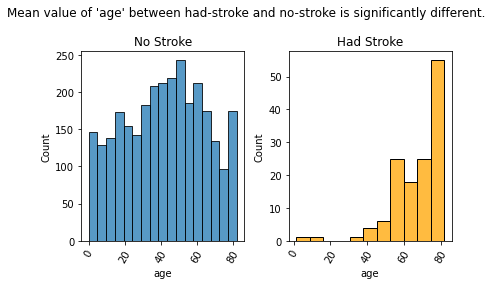

-------------------- bmi --------------------


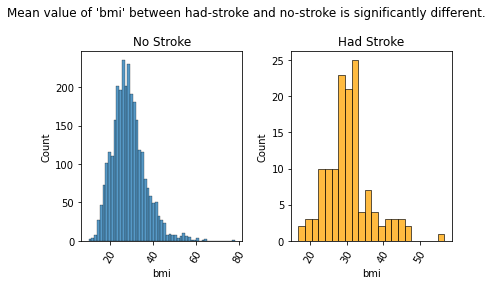

-------------------- avg_glucose_level --------------------


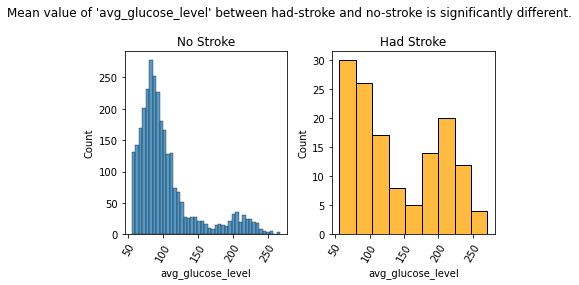

-------------------- high_glucose --------------------


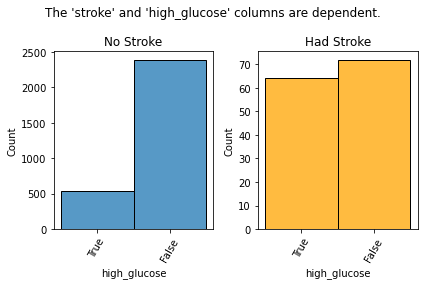

-------------------- has_hypertension --------------------


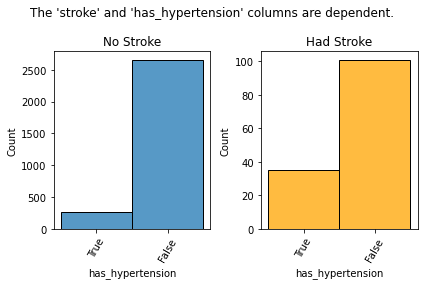

-------------------- has_heart_disease --------------------


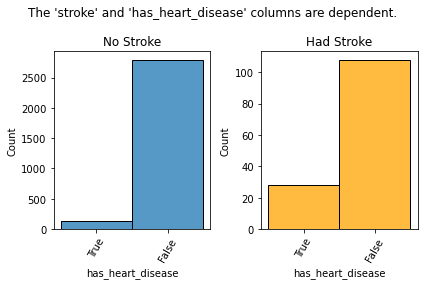

-------------------- ever_married --------------------


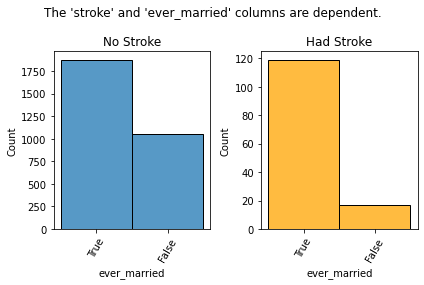

-------------------- is_female --------------------


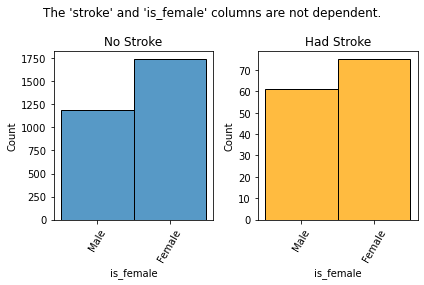

-------------------- is_urban --------------------


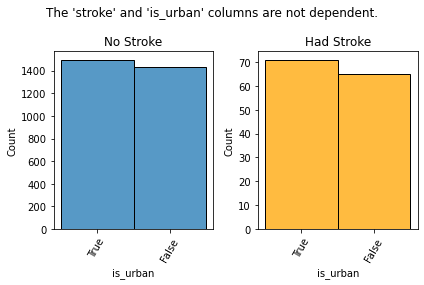

-------------------- current_smoker --------------------


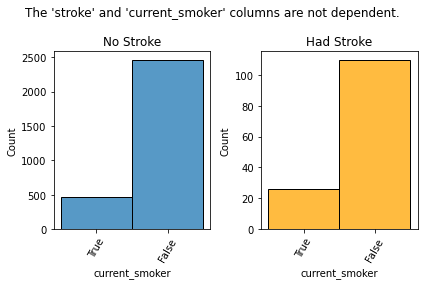

-------------------- prior_smoker --------------------


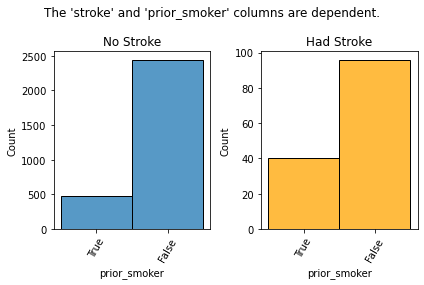

-------------------- never_smoked --------------------


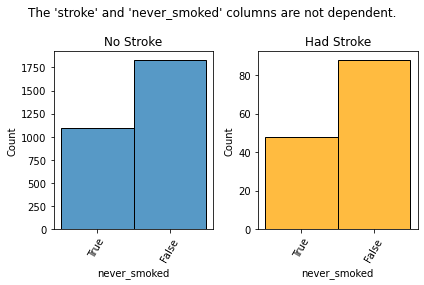

-------------------- govt_job --------------------


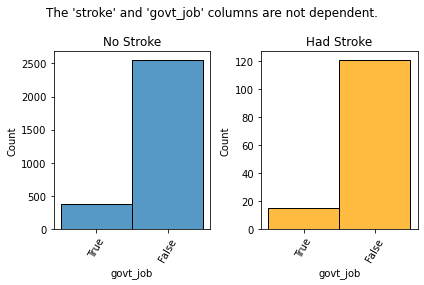

-------------------- self_employed --------------------


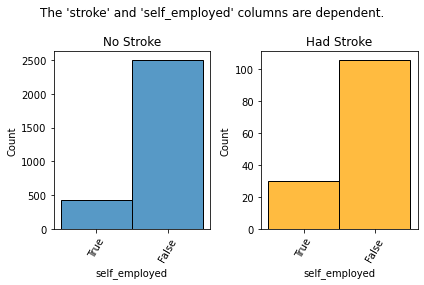

-------------------- private_work --------------------


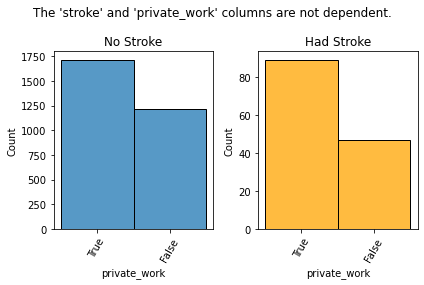

-------------------- never_worked --------------------


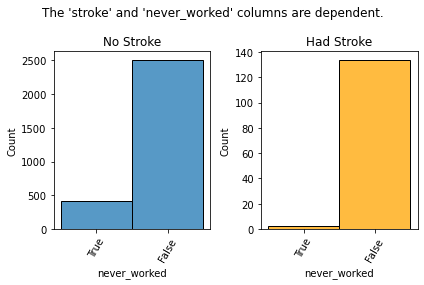

In [20]:
# initial chart look (looking for differences between left chart and right chart for each)
col_list_to_drop = ['stroke','is_senior','age_range','bmi_range','smoking_status']
for col in train.drop(columns=col_list_to_drop).columns:
    print('-'*20, col, '-'*20)
    # visualization
    plt.subplot(121) # Observations without stroke (left charts)
    plt.title('No Stroke')
    sns.histplot(train[train.stroke == 0][col].sort_values(ascending=False))
    plt.xticks(rotation=60)
    plt.subplot(122) # Observations with stroke (right charts)
    plt.title('Had Stroke')
    sns.histplot(train[train.stroke == 1][col].sort_values(ascending=False), color='#ffa500')
    plt.xticks(rotation=60)
    plt.suptitle(statement_dict[col]) # use statement from stats tests as viz title
    plt.tight_layout()
    plt.show()

## Results of Initial Bivariate Visualizations
Features **with significant differences** between No Stroke and Had Stroke (**keep**):
- age
- bmi
- avg_glucose_level
- high_glucose
- has_hypertension
- has_heart_disease
- ever_married
- prior_smoker
- self_employed
- never_worked

Features **without significant differences** between No Stroke and Had Stroke (**remove**):
- is_female
- is_urban
- current_smoker
- never_smoked
- govt_job
- private_work

In [21]:
# drop the 'remove' features from our exploration split
train = train.drop(columns=['is_female','is_urban',
                            'current_smoker','never_smoked',
                            'govt_job','private_work'])

# print current columns
print(train.columns.tolist())

['stroke', 'age', 'age_range', 'is_senior', 'bmi', 'bmi_range', 'avg_glucose_level', 'high_glucose', 'has_hypertension', 'has_heart_disease', 'ever_married', 'smoking_status', 'prior_smoker', 'self_employed', 'never_worked']


## Effects of Hyperglycemia Seen in Stroke Data
By way of the initial bivariate visualizations, the team noticed that the distribution for average glucose level is different between those who have had a stroke and those who have not. Proportionally, there are more values in the upper glucose range for those who have had a stroke. This can be seen in the following chart.

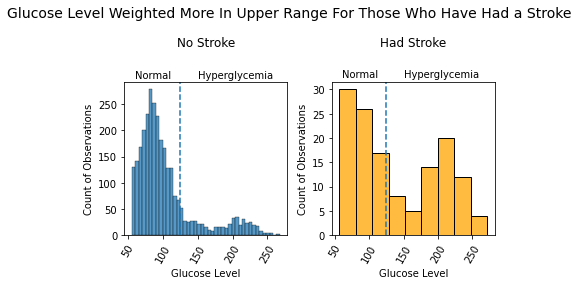

In [22]:
# show Stroke chart has larger ratio of values on right side of 125-mark dotted line
plt.subplot(121) # Observations without stroke (left charts)
plt.title('No Stroke\n\n')
sns.histplot(train[train.stroke == 0]['avg_glucose_level'].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.xlabel('Glucose Level')
plt.ylabel('Count of Observations')
plt.axvline(x=125, linestyle='--')
plt.text(60,300,'Normal',rotation=0)
plt.text(150,300,'Hyperglycemia',rotation=0)
plt.subplot(122) # Observations with stroke (right charts)
plt.title('Had Stroke\n\n')
sns.histplot(train[train.stroke == 1]['avg_glucose_level'].sort_values(ascending=False), color='#ffa500')
plt.xticks(rotation=60)
plt.xlabel('Glucose Level')
plt.ylabel('Count of Observations')
plt.axvline(x=125, linestyle='--')
plt.text(60,32.5,'Normal',rotation=0)
plt.text(150,32.5,'Hyperglycemia',rotation=0)
plt.suptitle('Glucose Level Weighted More In Upper Range For Those Who Have Had a Stroke',
             fontsize=14) # use statement from stats tests as viz title
plt.tight_layout()
plt.show()

Based on the chart, we've split the data into a new feature called high_glucose, which categorizes glucose level into those exceeding 125 and those below 125. **The number derived for this split comes from the chart, but corresponds with the medical definition of hyperglycemia, at 125 mmol/L.**

## Age May Drive Other Features
The 'age' column has a significant difference in distribution between no-stroke and stroke. The team suspects that **age may be driving stroke occurrence and also driving other features.** It's possible that some features may not drive stroke occurrence- only appear to do so because they are being driven by age, which (likely) is driving stroke.

The following visualization shows the difference that prompted this investigation.

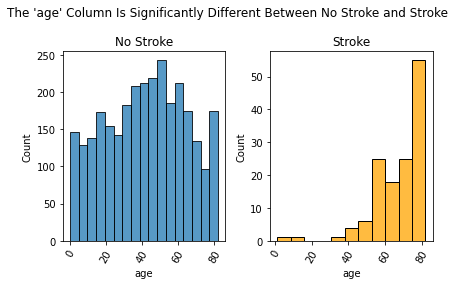

In [23]:
# show the difference in distribution for age between no stroke and stroke
plt.subplot(121) # Observations without stroke (left charts)
plt.title('No Stroke')
sns.histplot(train[train.stroke == 0]['age'].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.subplot(122) # Observations with stroke (right charts)
plt.title('Stroke')
sns.histplot(train[train.stroke == 1]['age'].sort_values(ascending=False), color='#ffa500')
plt.xticks(rotation=60)
plt.suptitle("The 'age' Column Is Significantly Different Between No Stroke and Stroke")
plt.tight_layout()
plt.show()

## Determining if Age Matters for a Feature
### Visual Determination - Continuous Independent Variables
To check visually if continuous features differ on stroke regardless of age, we will use the feature 'is_senior' to split the data into two age-group samples, Over-55 and Under-55. Then, we will calculate the mean value for the continuous feature for all four combinations of stroke and age-group classes. We will inspect the height differences in a bar chart of the four values. The implementation is in the following charts.

Steps:
1. Look for how much bigger/smaller the orange bar is to the blue for Under 55 Years Old.
2. Look at the size difference for Over 55 Years Old.
3. Compare the size difference of Under 55's blue/orange ratio to Over 55's blue/orange ratio.
4. Takeaways come from the comparison in step 3.

### 1. BMI

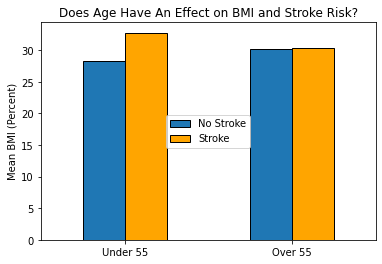

In [24]:
# calculate values for chart
stroke_bmi = train.groupby(['is_senior','stroke']).bmi.mean().unstack()
stroke_bmi.rename(columns={0:'No Stroke', 1:'Stroke'},
                  index = {"False":'Under 55', "True":'Over 55'},
                  inplace=True)

# plot
stroke_bmi.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('Does Age Have An Effect on BMI and Stroke Risk?')
plt.xlabel('')
plt.ylabel('Mean BMI (Percent)')
plt.legend(loc='center')
plt.show()

- BMI is slightly higher for those under 55 years old who have had a stroke, but even for those over 55.
- BMI is similar between age groups.

### 2. Average Glucose Level

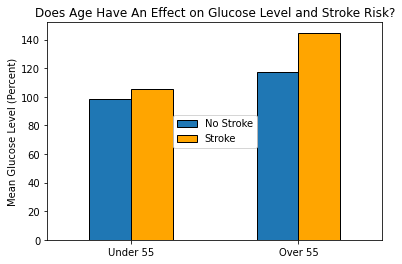

In [25]:
# calculate values for chart
stroke_avg_glucose_level = train.groupby(['is_senior','stroke']).avg_glucose_level.mean().unstack()
stroke_avg_glucose_level.rename(columns={0:'No Stroke', 1:'Stroke'},
                  index = {"False":'Under 55', "True":'Over 55'},
                  inplace=True)

# plot
stroke_avg_glucose_level.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('Does Age Have An Effect on Glucose Level and Stroke Risk?')
plt.xlabel('')
plt.ylabel('Mean Glucose Level (Percent)')
plt.legend(loc='center')
plt.show()

- Glucose level is higher for those who have had a stroke in both age groups, but it's a larger difference for those over 55 years old.
- People over 55 years old have a higher glucose level overall than those under 55 years old.

### Visual Determination - Categorical Independent Variables
To check visually if categorical features differ on stroke regardless of age, we will use the feature 'is_senior' to split the data into two age-group samples, Over-55 and Under-55, then inspect bar height differences. The implementation is in the following charts.

Steps:
1. Look for how much bigger/smaller the orange bar is to the blue for Under 55 Years Old.
2. Look at the size difference for Over 55 Years Old.
3. Compare the size difference of Under 55's blue/orange ratio to Over 55's blue/orange ratio.
4. Takeaways come from the comparison in step 3.

### 1. Hyperglycemia (High Glucose)

In [26]:
# Over, Under 55 Years Old: Hyperglycemia and Stroke
stroke_high_glucose = train.groupby(['is_senior','high_glucose']).stroke.mean().unstack()
stroke_high_glucose.rename(columns={"False": "Glucose Under 125",
                                    "True": "Glucose Over 125"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

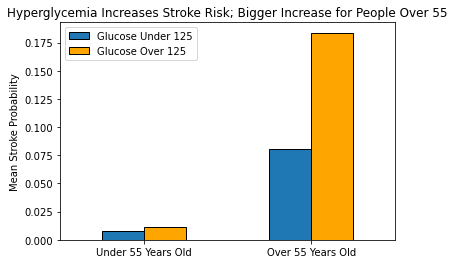

In [27]:
stroke_high_glucose.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Hyperglycemia Increases Stroke Risk; Bigger Increase for People Over 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those with hyperglycemia have a higher stroke occurence rate in both age groups.
- The difference is much more significant for those over 55 years old.

### 2. Hypertension

In [28]:
# Over, Under 55 Years Old: Hypertension and Stroke
stroke_has_hypertension = train.groupby(['is_senior','has_hypertension']).stroke.mean().unstack()
stroke_has_hypertension.rename(columns={"False": "No Hypertension",
                                        "True": "Has Hypertension"},
                               index = {"False": "Under 55 Years Old",
                                        "True": "Over 55 Years Old"},
                               inplace=True)

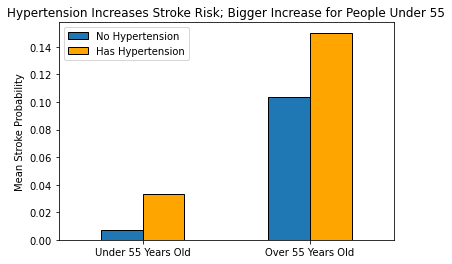

In [29]:
stroke_has_hypertension.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Hypertension Increases Stroke Risk; Bigger Increase for People Under 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those who have had a stroke have higher rates of hypertension for both age groups.
- People who have had a stroke under 55 years old have what seems to be a 3x increase of hypertension rate over those without hypertension in the same age group.
- The hypertension ratio between had-stroke and no-stroke for those over 55 years old is much less significant than the ratio for those under 55 years old.

### 3. Heart Disease

In [30]:
# Over, Under 55 Years Old: Heart Disease and Stroke
stroke_has_heart_disease = train.groupby(['is_senior','has_heart_disease']).stroke.mean().unstack()
stroke_has_heart_disease.rename(columns={"False": "No Heart Disease",
                                         "True": "Has Heart Disease"},
                                index = {"False": "Under 55 Years Old",
                                         "True": "Over 55 Years Old"},
                                inplace=True)

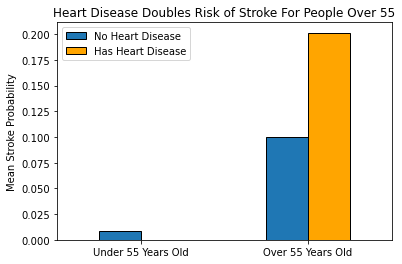

In [31]:
stroke_has_heart_disease.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Heart Disease Doubles Risk of Stroke For People Over 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Heart disease belongs entirely to those over 55 years old for the ~3,000 observations in our dataset.
- Heart disease seems to double the stroke occurrence rate.

### 4. Ever-Married

In [32]:
# Over, Under 55 Years Old: Ever Married and Stroke
stroke_ever_married = train.groupby(['is_senior','ever_married']).stroke.mean().unstack()
stroke_ever_married.rename(columns={"False": "Never Married",
                                    "True": "Married Before or Now"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

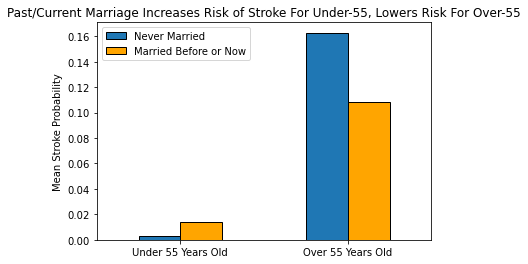

In [33]:
stroke_ever_married.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Past/Current Marriage Increases Risk of Stroke For Under-55, Lowers Risk For Over-55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- The stroke occurrence rate increases for those who married under 55 years old, but decreases for those married over 55 years old.
- The stroke occurrence rate for those who married under 55 years old is nearly triple the rate of those who have not married in the same age group.

### 5. Prior Smoker

In [34]:
# Over, Under 55 Years Old: Prior Smoker and Stroke
stroke_prior_smoker = train.groupby(['is_senior','prior_smoker']).stroke.mean().unstack()
stroke_prior_smoker.rename(columns={"False": "Never Began or Quit Smoking",
                                    "True": "Quit Smoking"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

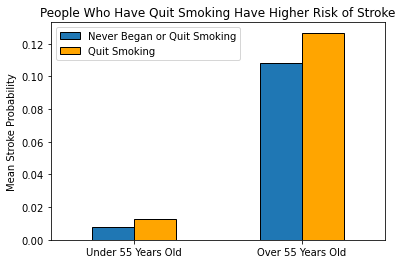

In [35]:
stroke_prior_smoker.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("People Who Have Quit Smoking Have Higher Risk of Stroke")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- People who have specifically quit smoking- excluding those who have never smoked and those who are currently smoking- have a higher stroke occurrence rate in both age groups.
- The ratio for both age groups seems similar, indicating this feature may be dependent on age.

### 6. Self-Employed

In [36]:
# Over, Under 55 Years Old: Self-Employed and Stroke
stroke_self_employed = train.groupby(['is_senior','self_employed']).stroke.mean().unstack()
stroke_self_employed.rename(columns={"False": "Not Self-Employed",
                                    "True": "Self-Employed"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

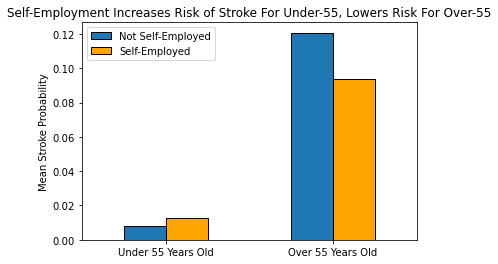

In [37]:
stroke_self_employed.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Self-Employment Increases Risk of Stroke For Under-55, Lowers Risk For Over-55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those who are self-employed and under 55 years old have a higher stroke occurrence rate than the rest of their age group.
- Those who are self-employed and over 55 years old have a lower stroke occurence rate than the rest of their age group.

### 7. Never-Worked

In [38]:
# Over, Under 55 Years Old: Never-Worked and Stroke
stroke_never_worked = train.groupby(['is_senior','never_worked']).stroke.mean().unstack()
stroke_never_worked.rename(columns={"False": "Previously/Currently Employed",
                                    "True": "Never Worked"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

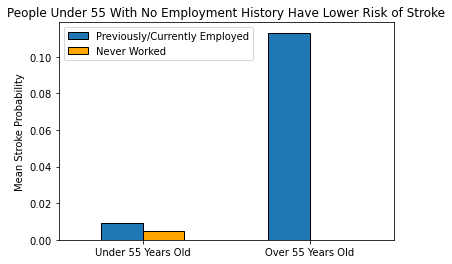

In [39]:
stroke_never_worked.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("People Under 55 With No Employment History Have Lower Risk of Stroke")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those with no employment history belong entirely to those under 55 years old for our 3,000-observation dataset.
- The stroke occurrence rate of those under 55 years old halves for those who have never worked before.

## Statistical Determination
Using the under-55 and over-55 splits, we will run statistical tests between stroke and a feature on one split, then run it on another split. 
- If the stroke is dependent on the feature in at least one age-group split, then we will keep the feature.
- If the stroke is independent from the feature on both age-group splits, the feature is independent from stroke and will be removed.

### Continuous Features - Comparison of Means, once for each age group

In [40]:
# set alpha
alpha = .05
# create over-55 and under-55 samples
over_55 = train[train.age >= 55]
under_55 = train[train.age < 55]

In [41]:
# create helper function to print results
def double_compare_means(t1, p1, t2, p2, alpha):
    """ 
        Compares p-values for Stroke and a feature for Stroke Prediction dataset, 
        Prints results.
    """
    if p1 < alpha and t1 != 0:
        if p2 < alpha and t2 != 0:
            print(f'Between had-stroke and no-stroke, mean value for {col} is different for both age groups.')
        else:
            print(f'Between had-stroke and no-stroke, mean value for {col} is different for over-55, not different for under-55.')
    else:
        if p2 < alpha and t2 != 0:
            print(f'Between had-stroke and no-stroke, mean value for {col} is not different for over-55, different for under-55.')

        else:
            print(f'Between had-stroke and no-stroke, mean value for {col} is not different for both age groups.')

    
    print('')

In [42]:
for col in ['bmi', 'avg_glucose_level']:
    # run test for both age group samples
    t_old, p_old = stats.mannwhitneyu(over_55[over_55.stroke == 1][col],
                                      over_55[over_55.stroke == 0][col],
                                      alternative='two-sided')
    t_young, p_young = stats.mannwhitneyu(under_55[under_55.stroke == 1][col],
                                      under_55[under_55.stroke == 0][col],
                                      alternative='two-sided')
    # print results
    double_compare_means(t_old, p_old, t_young, p_young, alpha)

Between had-stroke and no-stroke, mean value for bmi is not different for over-55, different for under-55.

Between had-stroke and no-stroke, mean value for avg_glucose_level is different for over-55, not different for under-55.



### Categorical Features - Independence Tests, once for each age group

In [43]:
# set alpha
alpha = .05
# create over-55 and under-55 samples
over_55 = train[train.age >= 55]
under_55 = train[train.age < 55]

In [44]:
# create helper function to print results
def double_independence(p1, p2, alpha):
    """ 
        Compares p-values for Stroke and a feature for Stroke Prediction dataset, 
        Prints results.
    """
    if p1 < alpha:
        if p2 < alpha:
            print(f'{col} and stroke are dependent for both age samples.')
        else:
            print(f'{col} and stroke are dependent for over-55, independent for under-55.')
    else:
        if p2 < alpha:
            print(f'{col} and stroke are independent for over-55, dependent for under-55.')
        else:
            print(f'{col} and stroke are independent for both age samples.')
    
    print('')

In [45]:
# iterate through categorical columns
for col in train.drop(columns='smoking_status').columns[7:]:
    # create crosstabs for stroke and a column for each sample
    over_55_crosstab = pd.crosstab(over_55['stroke'], over_55[col])
    under_55_crosstab = pd.crosstab(under_55['stroke'], under_55[col])
    # run chi2 tests for each sample on stroke and a column
    chi2_over55, p_over55,\
    degf_over55, expected_over55 = stats.chi2_contingency(over_55_crosstab)
    chi2_under55, p_under55,\
    degf_under55, expected_under55 = stats.chi2_contingency(under_55_crosstab)
    # print results
    double_independence(p_over55, p_under55, alpha)

high_glucose and stroke are dependent for over-55, independent for under-55.

has_hypertension and stroke are independent for over-55, dependent for under-55.

has_heart_disease and stroke are dependent for over-55, independent for under-55.

ever_married and stroke are independent for over-55, dependent for under-55.

prior_smoker and stroke are independent for both age samples.

self_employed and stroke are independent for both age samples.

never_worked and stroke are independent for both age samples.



# <center>Exploration Takeaways
## Initial Hypotheses Results
> #### We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.
> #### We are 95% confident that people who have had a stroke are older on average than people who have not.
> #### We are 95% confident that smoking has an impact on stroke occurrence.
> #### We can't say with 95% confidence that men and women have different stroke occurrence rates.

## Initial Bivariate Visualization Results
Features **with significant differences** between No Stroke and Had Stroke (**keep**):
- age
- bmi
- avg_glucose_level
- high_glucose
- has_hypertension
- has_heart_disease
- ever_married
- prior_smoker
- self_employed
- never_worked

Features **without significant differences** between No Stroke and Had Stroke (**remove**):
- is_female
- is_urban
- current_smoker
- never_smoked
- govt_job
- private_work

**Other Results:**
- **Hyperglycemia seems to have an impact on stroke risk** (not controlling for age)
- **Age may be driving other features**

## Multivariate Visualization Results (Controlling for Age)
**BMI:**
- BMI is slightly higher for those under 55 years old who have had a stroke, but even for those over 55.
- BMI is similar between age groups.

**Average Glucose Level:**
- Glucose level is higher for those who have had a stroke in both age groups, but it's a larger difference for those over 55 years old.
- People over 55 years old have a higher glucose level overall than those under 55 years old.

**Hyperglycemia:**
- Those with hyperglycemia have a higher stroke occurence rate in both age groups.
- The difference is much more significant for those over 55 years old.

**Hypertension:**
- Those who have had a stroke have higher rates of hypertension for both age groups.
- People who have had a stroke under 55 years old have what seems to be a 3x increase of hypertension rate over those without hypertension in the same age group.
- The hypertension ratio between had-stroke and no-stroke for those over 55 years old is much less significant than the ratio for those under 55 years old.

**Heart Disease:**
- Heart disease belongs entirely to those over 55 years old for the ~3,000 observations in our dataset.
- Heart disease seems to double the stroke occurrence rate.

**Prior/Current Married:**
- The stroke occurrence rate increases for those who married under 55 years old, but decreases for those married over 55 years old.
- The stroke occurrence rate for those who married under 55 years old is nearly triple the rate of those who have not married in the same age group.

**Specifically Quit-Smoking:**
- People who have specifically quit smoking- excluding those who have never smoked and those who are currently smoking- have a higher stroke occurrence rate in both age groups.
- The ratio for both age groups seems similar, indicating this feature may be dependent on age.

**Self-Employed:**
- Those who are self-employed and under 55 years old have a higher stroke occurrence rate than the rest of their age group.
- Those who are self-employed and over 55 years old have a lower stroke occurence rate than the rest of their age group.

**No Employment History:**
- Those with no employment history belong entirely to those under 55 years old for our 3,000-observation dataset.
- The stroke occurrence rate of those under 55 years old halves for those who have never worked before.

## Multivariate Statistical Testing Results (Controlling for Age)

**Categorical: Dependent for one age sample (driving stroke):**
1. **high_glucose** and stroke are **dependent for over-55**, independent for under-55.
1. **has_hypertension** and stroke are independent for over-55, **dependent for under-55**.
1. **has_heart_disease** and stroke are **dependent for over-55**, independent for under-55.
1. **ever_married** and stroke are independent for over-55, **dependent for under-55**.

**Categorical: Independent on both age samples (not driving stroke):**
1. **prior_smoker** and stroke are **independent for both** age samples.
1. **self_employed** and stroke are **independent for both** age samples.
1. **never_worked** and stroke are **independent for both** age samples.
    
**Continuous Independent Variable Results:**
1. Between had-stroke and no-stroke, mean value for **bmi** is **not different for over-55,** different for under-55.
1. Between had-stroke and no-stroke, mean value for **avg_glucose_level** is different for over-55, **not different for under-55.**
    
## Choosing Features for Modeling
For modeling purposes, we will only incorporate: 
- categorical features that we found to have a dependent relationship when controlling for age;
- continuous features that we found to have a statistically different mean value for between had-stroke and no-stroke when controlling for age.
    
### The features we will use for modeling are:
- **age**
- **high_glucose**
- **has_hypertension**
- **has_heart_disease**
- **ever_married**

In [46]:
# select the features we will use
train = train[['age','high_glucose','has_hypertension',
               'has_heart_disease','ever_married','stroke']]
validate = validate[['age','high_glucose','has_hypertension',
               'has_heart_disease','ever_married','stroke']]
test = test[['age','high_glucose','has_hypertension',
               'has_heart_disease','ever_married','stroke']]

In [47]:
# convert 'True' and 'False' values back to proper bool dtype (kept as string for explore)
for col in train.columns:
    if col not in ['stroke','age']:
        train[col] = train[col] == 'True'
        validate[col] = validate[col] == 'True'
        test[col] = test[col] == 'True'

In [48]:
# check work
validate.dtypes

age                  float64
high_glucose         boolean
has_hypertension     boolean
has_heart_disease    boolean
ever_married         boolean
stroke                 int64
dtype: object

# <center> 3. Model
## a. Modeling Overview
- Incorporated prepared data splits from Explore section
- Convert data to useful dtype for modeling
- Isolated target from each split
- Applied SMOTE + Tomek oversampling to Train split to balance target classes
- Built, fit multiple classification models on Train split
- Evaluated results of all models on Validate split
- Chose best model to evaluate on Test split
- Evaluated best model on Test split

## b. Building, Fitting Models
### Preparing for Modeling
First up is to prepare our data for modeling. We will convert the data into a format appropriate for modeling, then isolate the outcome variable from the independent variables.

In [49]:
# convert values to usable dtype for modeling
col_list = [col for col in train.columns if col != 'age'] # get cols to convert
for col in col_list:
    train[col] = train[col].astype('bool')
    validate[col] = validate[col].astype('bool')
    test[col] = test[col].astype('bool')

In [50]:
# isolate the target
X_train, y_train = train.drop(columns='stroke'), train.stroke
X_validate, y_validate = validate.drop(columns='stroke'), validate.stroke
X_test, y_test = test.drop(columns='stroke'), test.stroke

### Why We Apply SMOTE+Tomek
Next we will address the imbalance of classes in the 'stroke' target. As stated before, the no-stroke observations make up 95% of the dataset and the **had-stroke observations make up 5% of the dataset.** Before applying oversampling and undersampling with SMOTE+Tomek, we must first consider the effects of the techniques.

**Our team wants to optimize for recall (to predict as many stroke occurences as possible),** but we want to be somewhat accurate on all predictions instead of simply predicting all observations as "had-stroke." **SMOTE+Tomek will sharply increase recall score** while somewhat decreasing precision score due to the nature of generating artificial observations for model training. With this dataset's class imbalance and the goal being to optimize model recall, using SMOTE+Tomek is justified.

In [51]:
# apply SMOTE+Tomek oversampling
X_train_smtom, y_train_smtom = model.smoter(X_train, y_train)

Before SMOTE applied: (3063, 5) (3063,)
After SMOTE applied: (5854, 5) (5854,)


### Fit Models on Data, Return Predictions
After preparing the data for modeling, we use a script to generate various models with hyperparameter combinations, fit them on our data, and return their predictions so that we can evaluate model performance. We will predict on the Train split and Validate split for all models to check performance on known data and unknown data.

In [52]:
# script: build models, fit on train, predict on train and validate, return predictions
y_train_preds, y_validate_preds = model.classification_shotgun(X_train_smtom,
                                                               y_train_smtom,
                                                               X_validate,
                                                               y_validate)
y_train_preds.head()

,in_actuals,baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,nb_vsmooth0.0001,nb_vsmooth0.001,nb_vsmooth0.01,nb_vsmooth10,nb_vsmooth100,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75
0,False,False,False,False,True,False,False,False,False,False,...,True,False,False,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


### Append Baseline Prediction to Prediction Dataframe
Because we're trying to predict stroke, we will select the had-stroke outcome as our baseline and compare our models' results to it.

In [53]:
# new column where every prediction is had-stroke, for our baseline
y_train_preds['had_stroke_baseline'] = True
y_validate_preds['had_stroke_baseline'] = True

## c. Model Performance on Train, Validate
### Model Evaluation Script
Using the predictions dataframes, we will call our evaluation script and return the performance of each model on various metrics.

In [54]:
# script: evaluate each model's accuracy and recall
model_performances = model.print_classification_results(y_train_preds, 
                                                        y_validate_preds)

# show all model results
model_performances

,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall,InSample_Precision,OutSample_Precision,InSample_F1_Score,OutSample_F1_Score
0,baseline,0.5000,0.9423,0.0000,0.0000,NaN,NaN,NaN,NaN
1,tree_maxdepth1,0.7837,0.6732,0.9013,0.8814,0.7297,0.1372,0.8065,0.2374
2,tree_maxdepth2,0.7837,0.6732,0.9013,0.8814,0.7297,0.1372,0.8065,0.2374
3,tree_maxdepth3,0.8148,0.8014,0.7998,0.6102,0.8246,0.1667,0.8120,0.2618
4,tree_maxdepth5,0.8541,0.7984,0.8695,0.5254,0.8436,0.1483,0.8563,0.2313
5,tree_maxdepth10,0.9216,0.8366,0.9597,0.4407,0.8917,0.1625,0.9245,0.2374
6,rf_depth1,0.7989,0.7153,0.8797,0.7797,0.7574,0.1420,0.8140,0.2402
7,rf_depth2,0.8042,0.7162,0.8914,0.8305,0.7591,0.1489,0.8199,0.2526
8,rf_depth3,0.8123,0.7270,0.9009,0.7966,0.7652,0.1497,0.8276,0.2520
9,rf_depth5,0.8550,0.7867,0.9047,0.6610,0.8229,0.1646,0.8618,0.2635


### Choosing the Best-Performing Models
Since we're optimizing for recall while trying to be somewhat accurate, we will consider the models that do best in both metrics.

In [55]:
# return only highest-performing models
best_models = ((model_performances.OutSample_Recall > .8) &
               (model_performances.OutSample_Accuracy > .6))

model_performances[best_models]

,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall,InSample_Precision,OutSample_Precision,InSample_F1_Score,OutSample_F1_Score
1,tree_maxdepth1,0.7837,0.6732,0.9013,0.8814,0.7297,0.1372,0.8065,0.2374
2,tree_maxdepth2,0.7837,0.6732,0.9013,0.8814,0.7297,0.1372,0.8065,0.2374
7,rf_depth2,0.8042,0.7162,0.8914,0.8305,0.7591,0.1489,0.8199,0.2526
18,nb_vsmooth0.001,0.8005,0.6830,0.9108,0.8475,0.7462,0.1370,0.8203,0.2358
19,nb_vsmooth0.01,0.7829,0.6624,0.9026,0.8814,0.7282,0.1333,0.8061,0.2316


### ROC Curve and ROC AUC Calculation
Using our top five models, we will create ROC Curves and calculate area under the curve (AUC) to see which model performs best. We will choose that model as our best performing model of all models.

Because we created our models with a script, we will re-create the models with the same hyperparameters here, fit on the same in-sample data (Train), then use out-of-sample data (Validate) to calculate ROC AUC and build the ROC curve.

In [56]:
# build, fit the best models and the baseline
bl_probs = [0 for _ in range(len(y_validate))]

tree_maxdepth1 = DecisionTreeClassifier(max_depth=1, random_state=123).fit(X_train_smtom,
                                                                           y_train_smtom)
tree_maxdepth2 = DecisionTreeClassifier(max_depth=2, random_state=123).fit(X_train_smtom,
                                                                           y_train_smtom)
rf_maxdepth2 = RandomForestClassifier(max_depth=2, random_state=123).fit(X_train_smtom,
                                                                      y_train_smtom)
nb_vsmooth001 = GaussianNB(var_smoothing=.001).fit(X_train_smtom, y_train_smtom)

nb_vsmooth01 = GaussianNB(var_smoothing=.01).fit(X_train_smtom, y_train_smtom)

In [57]:
# calculate prediction probabilities on Validate for each model
tree_maxdepth1_probs = tree_maxdepth1.predict_proba(X_validate)
tree_maxdepth2_probs = tree_maxdepth2.predict_proba(X_validate)
rf_maxdepth2_probs = rf_maxdepth2.predict_proba(X_validate)
nb_vsmooth001_probs = nb_vsmooth001.predict_proba(X_validate)
nb_vsmooth01_probs = nb_vsmooth01.predict_proba(X_validate)

In [58]:
# only use prediction percentages for had-stroke
tree_maxdepth1_probs = tree_maxdepth1_probs[:, 1]
tree_maxdepth2_probs = tree_maxdepth2_probs[:, 1]
rf_maxdepth2_probs = rf_maxdepth2_probs[:, 1]
nb_vsmooth001_probs = nb_vsmooth001_probs[:, 1]
nb_vsmooth01_probs = nb_vsmooth01_probs[:, 1]

In [59]:
# calculate AUC of each model
bl_auc = roc_auc_score(y_validate, bl_probs)
tree1_auc = roc_auc_score(y_validate, tree_maxdepth1_probs)
tree2_auc = roc_auc_score(y_validate, tree_maxdepth2_probs)
rf2_auc = roc_auc_score(y_validate, rf_maxdepth2_probs)
nb001_auc = roc_auc_score(y_validate, nb_vsmooth001_probs)
nb01_auc = roc_auc_score(y_validate, nb_vsmooth01_probs)

In [60]:
# print ROC AUC for each model
print('Baseline: ROC AUC=%.3f' % (bl_auc))
print('tree_maxdepth1: ROC AUC=%.3f' % (tree1_auc))
print('tree_maxdepth2: ROC AUC=%.3f' % (tree2_auc))
print('rf_maxdepth2: ROC AUC=%.3f' % (rf2_auc))
print('nb_vsmooth001: ROC AUC=%.3f' % (nb001_auc))
print('nb_vsmooth01: ROC AUC=%.3f' % (nb01_auc))

Baseline: ROC AUC=0.500
tree_maxdepth1: ROC AUC=0.771
tree_maxdepth2: ROC AUC=0.791
rf_maxdepth2: ROC AUC=0.827
nb_vsmooth001: ROC AUC=0.845
nb_vsmooth01: ROC AUC=0.849


**Our best model is GaussianNB(var_smoothing=.01).** We will now plot the ROC Curve for this model and the baseline.

In [61]:
# generate ROC curve for baseline and model with highest ROC AUC
bl_fpr, bl_tpr, _ = roc_curve(y_validate, bl_probs)
nb01_fpr, nb01_tpr, _ = roc_curve(y_validate, nb_vsmooth01_probs)

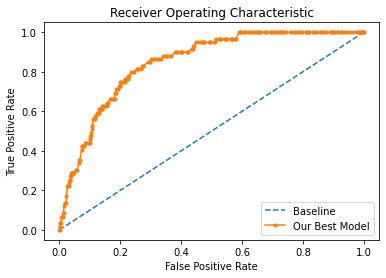

In [62]:
# plot ROC curve for baseline and best model
plt.plot(bl_fpr, bl_tpr, linestyle='--', label='Baseline')
plt.plot(nb01_fpr, nb01_tpr, marker='.', label='Our Best Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## d. Best Model's Performance on Test
Our best model is the Naive Bayes model. The specific implementation is GaussianNB(var_smoothing=.01). 

We will now evaluate this model's performance on the Test split, our sequestered out-of-sample split. We have not analyzed this data nor touched it with any models until this point. The idea is to see how the model performs on another out-of-sample split. This is a safety check to make sure our model performs just as well on out-of-sample data as it did for the Validate split.

In [63]:
# evaluating our best model's performance on Test
y_test_preds = nb_vsmooth01.predict(X_test)
recall = recall_score(y_test, y_test_preds)
accuracy = accuracy_score(y_test, y_test_preds)

# output results
print('Recall Score of Best Model: %.3f' % recall)
print('Accuracy Score of Best Model: %.3f' % accuracy)

Recall Score of Best Model: 0.833
Accuracy Score of Best Model: 0.648


# <center>Modeling Takeaways

### Features Used
- **age**
- **high_glucose**
- **has_hypertension**
- **has_heart_disease**
- **ever_married**

### Best Model: Naive Bayes with var_smoothing=.01
- **Recall: 83%**
- **Accuracy: 65%**
- **ROC AUC: 85%**

# <center> 4. Risk-Calculation Program
## Risk-Calculation Program Overview

### What it aims to do
- Provide users with a score indicating stroke risk where higher numbers are higher risk
- Uses our best model to calculate the risk score

### Instructions
- Write step-by-step instructions here

## Implementation with Sample Input

In [64]:
# call function here

# <center> Conclusion

## Conclusion
1. Note stats test takeaways
1. Note model performance
1. Explain takeaways
1. Conclude